In [ ]:
import os
import numpy as np
from downsampling import extract_single_shell
from utils import find_file, load_mrtrix


bval = 1000
bval_range = 20
directions = 32

path = '/media/ssr_dwi/MRgFUS_Database/'
dwi_name = 'DWI_processed.mif.gz'
sub_list = sorted(os.listdir(path))

for i, sub in enumerate(sub_list):
    print(' '.join([' '] * 300), end='\r')
    print('Subject {:} [{:02d}/{:02d}]'.format(
        sub, i + 1, len(sub_list)
    ), end='\r')
    sub_path = os.path.join(path, sub, 'dwi')
    
    dwi_in = find_file(dwi_name, sub_path)
    image = os.path.basename(dwi_in)

    print(' '.join([' '] * 300), end='\r')
    print('Reading the MIF file {:} [{:02d}/{:02d}]'.format(
        sub, i + 1, len(sub_list)
    ), end='\r')
    mif = load_mrtrix(dwi_in)
    old_grad = mif.grad
    bvals = old_grad[:, -1]
    bvecs = old_grad[:, :-1]
    
    print(' '.join([' '] * 300), end='\r')
    print('Downsampling {:} [{:02d}/{:02d}]'.format(
        sub, i + 1, len(sub_list)
    ), end='\r')
    lr_bvecs, lr_bvals, lr_index, b0_index = extract_single_shell(
        bvals, bvecs, bval, bval_range, directions
    )
    lr_index = np.array(lr_index.tolist())
    lr_bvals = np.array([0] + lr_bvals.tolist())
    lr_bvecs = np.concatenate([np.zeros((1, 3)), lr_bvecs])
    new_grad = np.concatenate([lr_bvecs, lr_bvals.reshape(-1, 1)], axis=-1)

    mif_b0 = np.mean(mif.data[..., b0_index], axis=-1, keepdims=True)
    f_data = np.concatenate([mif_b0, mif.data[..., lr_index]], axis=-1)

    mif.data = f_data
    mif.grad = new_grad

    print(' '.join([' '] * 300), end='\r')
    print('Converting to MIF (Downsampled) {:} [{:02d}/{:02d}]'.format(
        sub, i + 1, len(sub_list)
    ), end='\r')
    out_name = os.path.join(
        sub_path, '{:}_{:}dir.mif.gz'.format(
            image.split('.')[0], directions
        )
    )
    mif.save(out_name)

b0s = data(:, :, :, bvals < 100); % all 18 b = 0 images <br>
meanb0 = mean(b0s, 4); % mean b = 0 images <br>
dwis = data(:, :, :, bvals > 100); % all 90 dwis <br>
bvals_dwi = bvals(bvals > 100); % bvals for dwis <br>
bvecs_dwi = bvecs(bvals > 100, :); % bvecs for dwis <br>

dirs = bvecs(bvals > 100, :); % 90 diffusion-encoding directions <br>
dirs_vis = dirs .* sign(dirs(:, 3)); % directions flipped to z > 0 for visualization <br>
sz_data = size(data); <br>

figure; % display image data  <br>
subplot(1, 2, 1) <br>
imshow(rot90(data(:, :, 35, 1)), [0, 10000]) <br>
title('b = 0 image'); <br>
subplot(1, 2, 2) <br>
imshow(rot90(data(:, :, 35, 2)), [0, 4000]) <br>
title('diffusion weighted image'); <br>

figure; % display diffusion encoding directions, all flipped to z > 0 <br>
plot3(dirs_vis(:, 1), dirs_vis(:, 2), dirs_vis(:, 3), '.'); <br>
grid on, axis equal <br>
zlim([-1, 1]) <br>
title('90 diffusion encoding directions'); <br>

In [151]:
from utils import load_mrtrix
from copy import deepcopy
mif_file = '/home/mariano/Downloads/100307_DWI_processed_b1000.mif.gz'
tolerance = 20
bval = 1000

mif = load_mrtrix(mif_file)
old_grad = mif.grad
grad_vals = old_grad[:, -1]
grad_vecs = old_grad[:, :-1]
fixed_dwi = deepcopy(mif.data)
fixed_dwi[fixed_dwi < 0] = 0

b0_mask = np.logical_and(bvals > -tolerance, bvals < tolerance)
b_mask = np.logical_and(bvals > bval - tolerance, bvals < bval + tolerance)
b0_images = fixed_dwi[..., b0_mask]
b_images = fixed_dwi[..., b_mask]
b_vecs = grad_vecs[b_mask, ...]
b_vals = grad_vals[b_mask]

# Optimized encoding directions (DSM)

6 optimized directions from the DSM scheme that minimize the condition number of the diffusion tensor transformation matrix while are as uniform as possible. From [S Skare et al., J Magn Reson. 2000;147(2):340-52.](https://www.sciencedirect.com/science/article/pii/S1090780700922092) based on [ISMRM2000 abstract](https://cds.ismrm.org/ismrm-2000/PDF3/0806.pdf).

```m
dsm6 = [0.91, 0.416, 0; ... 
               0, 0.91, 0.416; ...
               0.416, 0, 0.91; ...
               0.91, -0.416, 0; ...
               0, 0.91, -0.416; ...
              -0.416, 0, 0.91];

dsm6_norm = dsm6 ./ sqrt(dsm6(:, 1) .^ 2 + dsm6(:, 2) .^ 2 + dsm6(:, 3) .^ 2); % normalize vectors
```

In [152]:
import numpy as np

dsm6 = np.array([
    [  0.91,  0.416,      0],
    [     0,   0.91,  0.416],
    [ 0.416,      0,   0.91],
    [  0.91, -0.416,      0],
    [     0,   0.91, -0.416],
    [-0.416,      0,   0.91]
])
dsm6_norm = dsm6 / np.sqrt(np.sum(dsm6 ** 2, axis=-1, keepdims=True))

Diffusion tensor transformation matrix for given b vectors

```m
function A = amatrix(bvec)

A = [
bvec(:,1) .* bvec(:,1),  2 * bvec(:,1) .* bvec(:,2),  2 * bvec(:,1) .* bvec(:,3), ...
bvec(:,2) .* bvec(:,2),  2 * bvec(:,2) .* bvec(:,3),  bvec(:,3) .* bvec(:,3)
];
```

In [153]:
def  a_matrix(bvec):
    a = np.stack([ 
        bvec[:, 0] * bvec[:, 0],
        2 * bvec[:, 0] * bvec[:, 1],
        2 * bvec[:, 0] * bvec[:, 2],
        bvec[:, 1] * bvec[:, 1],
        2 * bvec[:, 1] * bvec[:, 2],
        bvec[:, 2] * bvec[:, 2],
    ], axis=-1)
    return a

print(a_matrix(b_vecs).shape)

(90, 6)


# Sampling

Randomly rotate the DSM6 dirs, select their nearest 6 dirs from acquired dirs, keep those with low condition number and angel difference. <br>

```m
rotang_all = [];
angerr_all  = [];
condnum_all = [];
ind_all = [];

for ii = 1 : 100000 % number of iterations can be increased in actual implementation
    rotangs = rand(1, 3) * 2 * pi; % random angles to rotate around x, y, z axis
    R = rot3d(rotangs); % rotation matrix
    dsm6_rot = (R * dsm6_norm')'; % roated directions
    % find 6 nearest dirs in acquired dirs
    angerrors = acosd(abs(dsm6_rot * dirs')); % angles btw rotated DSM6 dirs and acquired dirs
    [minerrors, ind] = min(angerrors, [], 2); % 6 dirs with min angles compared to rotated DSM6 dirs
    meanangerr = mean(minerrors); % mean angle errors of selected dirs
    condnum = cond(amatrix(dirs(ind, :))); % cond number of tensor tx matrix of selected dirs
    if meanangerr < 5 && condnum < 1.6 % only use dirs with low angle error and cond number
        if isempty(ind_all) || ~any(sum(ind_all == sort(ind'), 2) == 6) % make sure no repetition
            % record params for satisfied sets
            angerr_all = cat(1, angerr_all, meanangerr);
            condnum_all = cat(1, condnum_all, condnum);
            ind_all = cat(1, ind_all, sort(ind'));
            rotang_all = cat(1, rotang_all, rotangs);
        end
    end
end
```

In [154]:
def random_3D_rotation(vectors):
    # Vectors have shape (N, 3)
    if isinstance(vectors, list):
        vectors = np.array(vectors)
    norm_vectors = np.concatenate([
        vectors, np.ones((len(vectors), 1))
    ], axis=-1)
    angles = np.random.rand(3) * 2 * np.pi
    cos = np.cos(angles)
    sin = np.sin(angles)
    affine = np.eye(4)

    Rx = np.array([
        [1,       0,       0],
        [0,  cos[0], -sin[0]],
        [0,  sin[0],  cos[0]],
    ])
    Ry = np.array([
        [ cos[1],  0, sin[1]],
        [      0,  1,      0],
        [-sin[1],  0, cos[1]],
    ])
    Rz = np.array([
        [ cos[2], -sin[2], 0],
        [ sin[2],  cos[2], 0],
        [      0,       0, 1],
    ])
    R = Rz @ (Ry @ Rx)
    affine[:3, :3] = R
    
    new_vectors = affine @ norm_vectors.T

    return new_vectors.T[:, :-1]

all_samplings = []
all_condnum = []
for i in range(10000):
    dsm6_rot = random_3D_rotation(dsm6_norm)
    ang_error = np.arccos(dsm6_rot @ b_vecs.T)
    sampled_dirs = np.argmin(ang_error, axis=-1)
    mean_error = np.mean([
        ang_error[i, dir_i] for i, dir_i in enumerate(sampled_dirs)
    ])
    mean_error_d = mean_error * 180 / np.pi
    sampled_vecs = b_vecs[sampled_dirs, :]
    a = a_matrix(sampled_vecs)
    condnum = np.linalg.cond(a)
    if len(np.unique(sampled_dirs)) < 6 or mean_error_d > 5:
        pass
#         print('✘Nope', condnum, mean_error_d, sampled_dirs)
    else:
        sorted_dirs = np.sort(sampled_dirs)
        if np.all([np.any(sorted_dirs != s) for s in all_samplings]):
            all_samplings.append(sorted_dirs)
            all_condnum.append(condnum)
            print('✓Yes', condnum, mean_error_d, sorted_dirs)
        else:
            print('✘Repeated', sorted_dirs)

✓Yes 2.170807164508792 4.547621117418252 [ 9 10 53 63 78 82]
✓Yes 2.5853915183832883 4.622261595470388 [ 8  9 34 43 50 89]
✓Yes 1.667453374466057 4.802735917278099 [10 17 21 47 69 86]
✓Yes 2.035855665695438 4.957673687944159 [ 0 17 19 44 52 87]
✓Yes 1.7489364012851694 4.611068172723591 [26 35 52 72 82 85]
✓Yes 1.6666974516881294 4.851794632698247 [ 1 21 44 48 53 86]
✓Yes 1.8328755595901443 4.89668665805109 [ 1  5 26 35 52 72]
✓Yes 1.9909314974655796 4.375010415191298 [ 2 18 31 36 57 72]
✓Yes 1.710598138864638 4.88756686556524 [ 1 25 27 44 53 82]
✓Yes 1.651699457981387 4.805601610108198 [ 1 25 44 52 53 82]
✓Yes 2.3372474081609345 4.743923919488687 [19 23 34 44 58 77]
✓Yes 2.0599232407337604 4.56259315822536 [16 45 48 65 71 86]
✓Yes 2.079176598143841 4.808740680615175 [30 49 72 73 76 78]
✓Yes 2.001628611589612 4.431093160596794 [42 46 67 69 77 85]
✓Yes 2.10776745764091 4.923805917358593 [ 1 13 20 46 54 79]
✓Yes 2.3404296356602723 4.505149025428771 [ 4 60 61 66 68 87]
✘Repeated [ 4 60 61 

# Input generation

Here we only select 5 sets of directions with lowest condition number better to make sure all dwis can be equally slected and used for training 

```m
[~, ind_sort] = sort(condnum_all);
ind_use = ind_all(ind_sort(1 : 5), :);
condnum_use = condnum_all(ind_sort(1 : 5));
angerr_use = angerr_all(ind_sort(1 : 5));
rotang_use = rotang_all(ind_sort(1 : 5), :);
```

Generate input data of CNN
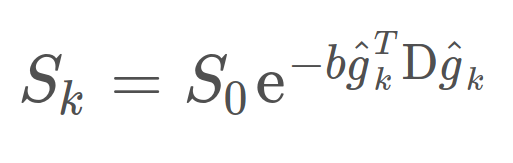

```m
input_all = {};
tensor_all = {};
bval_synth = 1000; % b value for synthesized dwis

for ii = 1 : 5
    b0 = b0s(:, :, :, ii); % a single b=0 image for each set of selected 6 dwis
    dwis6 = dwis(:, :, :, ind_use(ii, :));
    bvals6 = bvals_dwi(ind_use(ii, :));
    bvecs6 = bvecs_dwi(ind_use(ii, :), :);
    
    % compute apparent diffusion coefficients
    adcs6 = log(dwis6 ./ b0); % s = s0 * exp(-b * adc) 
    for jj = 1 : length(bvals6)
        adcs6(:, :, :, jj) = adcs6(:, :, :, jj) / (-bvals6(jj)); % in case bvalues might be different for acquired dwis
    end
    
    % compute tensors
    adcs6_vec = reshape(adcs6, sz_data(1)*sz_data(2)*sz_data(3), size(adcs6, 4)); % transform volume data to vectors
    A = amatrix(bvecs6); % tensor transformation matrix
    tensor_vec = A \ adcs6_vec'; %i.e., inv(A) * adcs_vec'; solve Ax = b
    tensor = reshape(tensor_vec', [sz_data(1:3), 6]); % transform tensors in vector form to volume
    tensor(isnan(tensor)) = 0;
    tensor(isinf(tensor)) = 0;
    tensor_all{ii} = tensor;

    % synthesize dwis along DSM6 dirs
    dwis6norm_vec_synth = exp(-bval_synth .* amatrix(dsm6_norm) * tensor_vec); % normalized dwi
    dwis6_synth = b0 .* reshape(dwis6norm_vec_synth', [sz_data(1:3), size(dwis6norm_vec_synth, 1)]);    
    dwis6_synth(isnan(dwis6_synth)) = 0;
    dwis6_synth(isinf(dwis6_synth)) = 0;
    
    diff_input = cat(4, b0, dwis6_synth);
    input_all{ii} = diff_input;
end
```

In [172]:
def dti_fit(dwi, bvecs, bvals, b0=None, tolerance=20):
    x, y, z = dwi.shape[:-1]
    # If b0 is not explicitly given, we need to split it using the bvals.
    if b0 is None:
        b0_mask = np.logical_and(bvals > -tolerance, bvals < tolerance)
        b_mask = np.logical_not(b0_mask)
        b0 = np.mean(dwi[..., b0_mask], axis=-1)
        dwi = dwi[..., b_mask]
        bvecs = bvecs[b_mask, ...]
        bvals = bvals[b_mask]
    # s = s0 * exp(-b * adc) 
    adcs = - np.log(dwi / np.expand_dims(b0, axis=-1)) / bvals.reshape((1, 1, 1, -1))
    adcs[np.isnan(adcs)] = 0
    adcs[np.isinf(adcs)] = 0
    b = np.swapaxes(np.reshape(adcs, (-1, len(bvals))), 0, 1)
    # i.e., inv(A) * adcs_vec'; solve Ax = b
    A = a_matrix(bvecs)
    tensor_vec, res, rnk, s = lstsq(A, b)
    tensor = np.reshape(
        np.swapaxes(tensor_vec, 0, 1),
        (x, y, z, -1)
    )
    return tensor, tensor_vec
        

In [181]:
from scipy.linalg import lstsq
import nibabel as nib
sorted_samples = np.argsort(all_condnum)
for i, sample_i in enumerate(sorted_samples[:5]):
    b0 = b0_images[..., np.random.randint(b0_images.shape[-1])]
    x, y, z = b0.shape
    current_sample = all_samplings[sample_i]
    dwis6 = b_images[..., current_sample]
    bvals6 = b_vals[current_sample]
    bvecs6 = b_vecs[current_sample, ...]
    tensor, tensor_vec = dti_fit(dwis6, bvecs6, bvals6, b0)
    nii = nib.Nifti1Image(tensor, np.eye(4))
    nii.to_filename('/home/mariano/Downloads/test_{:02d}.nii.gz'.format(i))
    dwis6norm_vec_synth = np.exp(-bval * a_matrix(dsm6_norm) @ tensor_vec)
    dwis6_synth = np.reshape(
        np.swapaxes(dwis6norm_vec_synth, 0, 1),
        (x, y, z, -1)
    )
    dwis6_synth *= np.expand_dims(b0, axis=-1)
    new_bvals = np.array([0] + [bval] * 6)
    new_bvecs = np.concatenate([np.zeros((1, 3)), dsm6_norm])
    new_grad = np.concatenate([new_bvecs, new_bvals.reshape(-1, 1)], axis=-1)

    f_data = np.concatenate([
        np.expand_dims(b0, axis=-1),
        dwis6_synth
    ], axis=-1)

    mif.data = f_data
    mif.grad = new_grad
    mif.save('/home/mariano/Downloads/DWI_{:02d}.mif.gz'.format(i))

# Ground truth (simulated)

Generate ground-truth data of CNN

```m
% compute apparent diffusion coefficients
adcs = log(dwis ./ meanb0); % s = b0 * exp(-b * adc)
for ii = 1 : size(adcs, 4)
    adcs(:, :, :, ii) = adcs(:, :, :, ii) / (-bvals_dwi(ii)); % in case bvalues might be different for acquired dwis
end

adcs_vec = reshape(adcs, sz_data(1)*sz_data(2)*sz_data(3), size(adcs, 4)); % tx volume data to vectors
tensor_gt_vec = amatrix(bvecs_dwi) \ adcs_vec'; % solve tensors
tensor_gt = reshape(tensor_gt_vec', [sz_data(1:3), 6]); % tx vectors to volume
tensor_gt(isnan(tensor_gt)) = 0;
tensor_gt(isinf(tensor_gt)) = 0;
```

Synthesize dwis along DSM6 dirs

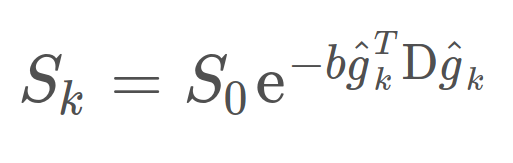

```m
dwis6norm_vec_gt = exp(-bval_synth .* amatrix(dsm6_norm) * tensor_gt_vec);
dwis6_gt = b0 .* reshape(dwis6norm_vec_gt', [sz_data(1:3), size(dwis6norm_vec_gt, 1)]);    
dwis6_gt(isnan(dwis6_gt)) = 0;
dwis6_gt(isinf(dwis6_gt)) = 0;
```

In [184]:
mean_b0 = np.mean(b0_images, axis=-1)
tensor_gt, tensor_gt_vec = dti_fit(b_images, b_vecs, b_vals, mean_b0)
nii = nib.Nifti1Image(tensor_gt, np.eye(4))
nii.to_filename('/home/mariano/Downloads/test_gt.nii.gz'.format(i))

dwis6norm_vec_gt = np.exp(-bval * a_matrix(dsm6_norm) @ tensor_gt_vec)
dwis6_gt = np.reshape(
    np.swapaxes(dwis6norm_vec_gt, 0, 1),
    (x, y, z, -1)
)
dwis6_gt *= np.expand_dims(mean_b0, axis=-1)
new_bvals = np.array([0] + [bval] * 6)
new_bvecs = np.concatenate([np.zeros((1, 3)), dsm6_norm])
new_grad = np.concatenate([new_bvecs, new_bvals.reshape(-1, 1)], axis=-1)

f_data = np.concatenate([
    np.expand_dims(mean_b0, axis=-1),
    dwis6_gt
], axis=-1)

mif.data = f_data
mif.grad = new_grad
mif.save('/home/mariano/Downloads/DWI_gt.mif.gz'.format(i))